<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- How does L1, L2 regularization work ?
-

In [1]:
!pip install d2l

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

from matplotlib import pyplot as plt
from d2l import torch as d2l

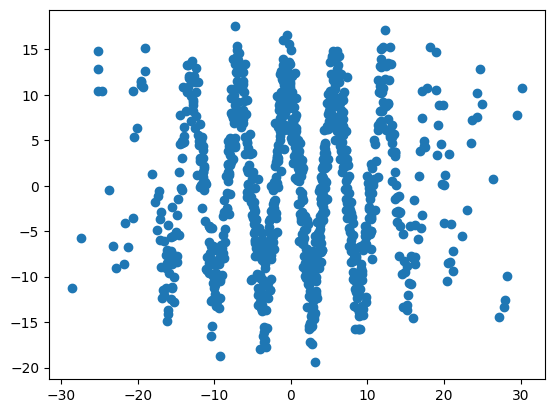

(torch.Size([1000, 2]), torch.Size([1000]))

In [2]:
def get_noisy_data(curve_weight, noise_weight, num_samples=1000):
  X = torch.randn(num_samples, 2) * curve_weight
  signal = curve_weight * torch.cos(X[:,0]) - curve_weight / 2 * torch.sin(X[:,0])
  noise = torch.randn(num_samples, ) * noise_weight
  assert(signal.shape == noise.shape)
  Y = signal + noise
  assert(Y.shape == (num_samples, ))
  return X, Y

X, Y = get_noisy_data(curve_weight=10, noise_weight=3, num_samples=1000)
plt.plot(X[:,0].unsqueeze(dim=-1), Y, 'o')
plt.show()
X.shape, Y.shape

In [3]:
class DataModule(d2l.HyperParameters):
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        inputs, outputs = get_noisy_data(curve_weight=10, noise_weight=3, num_samples=1000)
        self.dataset = TensorDataset(inputs, outputs)
        self.dataloader = DataLoader(self.dataset, batch_size=20, shuffle=True)
        return self.dataloader

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

my_dataset = DataModule()
my_dataset.train_dataloader()

In [8]:
class LinearRegression(d2l.Module):
  def __init__(self, lr=0.001):
    super().__init__()
    self.save_hyperparameters()
    self.hidden = nn.Linear(2, 1)

  def forward(self, X):
    return self.hidden(X)

  def loss(self, Y_hat, Y):
    return nn.functional.mse_loss(Y_hat, Y)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)

  def training_step(self, batch):
      l = self.loss(self(*batch[:-1]), batch[-1])
      self.plot('loss', l, train=True)
      if hasattr(self, 'train_losses') == False:
        self.train_losses = []
      self.train_losses.append(l)
      return l

  def validation_step(self, batch):
      l = self.loss(self(*batch[:-1]), batch[-1])
      self.plot('loss', l, train=False)
      if hasattr(self, 'val_losses') == False:
        self.val_losses = []
      self.val_losses.append(l)
      return l

model = LinearRegression()
model


LinearRegression(
  (hidden): Linear(in_features=2, out_features=1, bias=True)
)

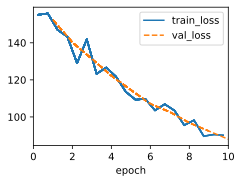

In [9]:
linear_model = LinearRegression(0.001)
linear_trainer = d2l.Trainer(max_epochs=10)
linear_trainer.fit(linear_model, my_dataset)

In [12]:
linear_model.train_losses[-1], linear_model.val_losses[-1]

(tensor(95.7340, grad_fn=<MseLossBackward0>), tensor(85.3560))

In [13]:
class NonLinearRegression(d2l.Module):
  def __init__(self, lr=0.001):
    super().__init__()
    self.save_hyperparameters()
    self.hidden = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        nn.Linear(1, 1)
    )

  def forward(self, X):
    return self.hidden(X)

  def loss(self, Y_hat, Y):
    return nn.functional.mse_loss(Y_hat, Y)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)

  def training_step(self, batch):
      l = self.loss(self(*batch[:-1]), batch[-1])
      self.plot('loss', l, train=True)
      if hasattr(self, 'train_losses') == False:
        self.train_losses = []
      self.train_losses.append(l)
      return l

  def validation_step(self, batch):
      l = self.loss(self(*batch[:-1]), batch[-1])
      self.plot('loss', l, train=False)
      if hasattr(self, 'val_losses') == False:
        self.val_losses = []
      self.val_losses.append(l)
      return l

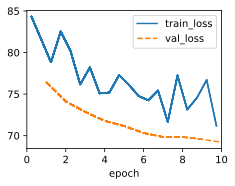

In [15]:
non_linear_model = NonLinearRegression(0.0001)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(non_linear_model, my_dataset)

In [18]:
non_linear_model.train_losses[-2], non_linear_model.val_losses[-2]

(tensor(66.5543, grad_fn=<MseLossBackward0>), tensor(57.2167))

In [19]:
len(non_linear_model.train_losses)

500